In [33]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from fbg import *
from scipy.signal import find_peaks

In [34]:
filepath = 'spectra_files/psg_trn.txt'
data = psg_to_numpy(filepath, verbose=False)

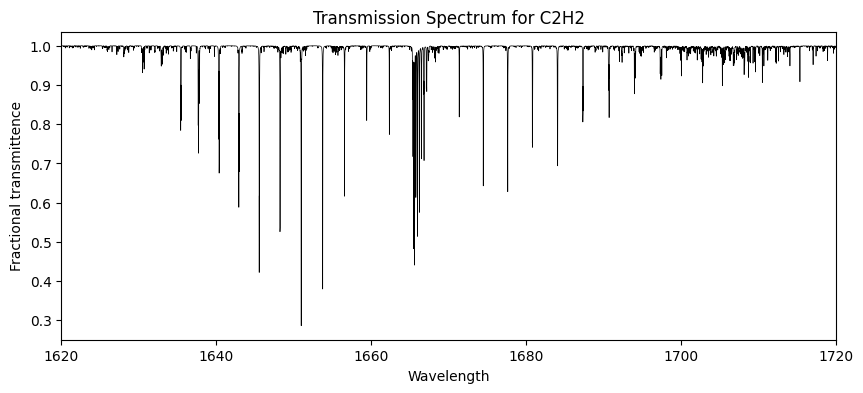

In [35]:
wavelength = data[:,0]*1e3

plt.figure(figsize=(10,4))
plt.plot(wavelength, data[:,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.xlim((1620,1720))
plt.show()

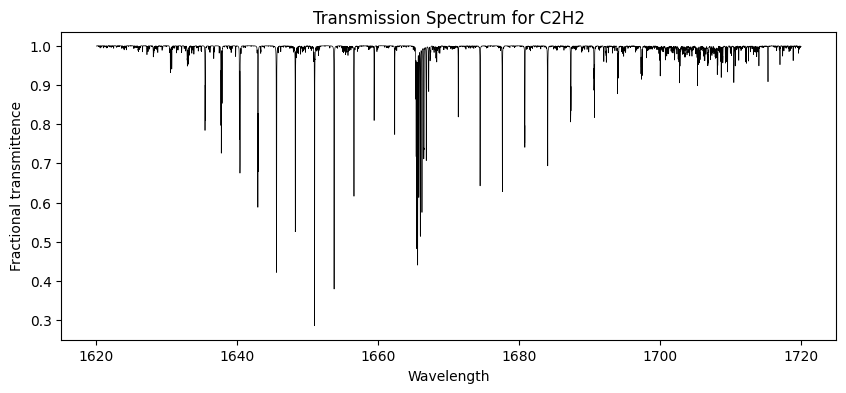

In [36]:
index_array =  np.where((wavelength>1620) & (wavelength<=1720))
index = index_array[0]

plt.figure(figsize=(10,4))
plt.plot(wavelength[index], data[index,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.show()

Locate peaks with minimal distance between peaks to eliminate split peaks

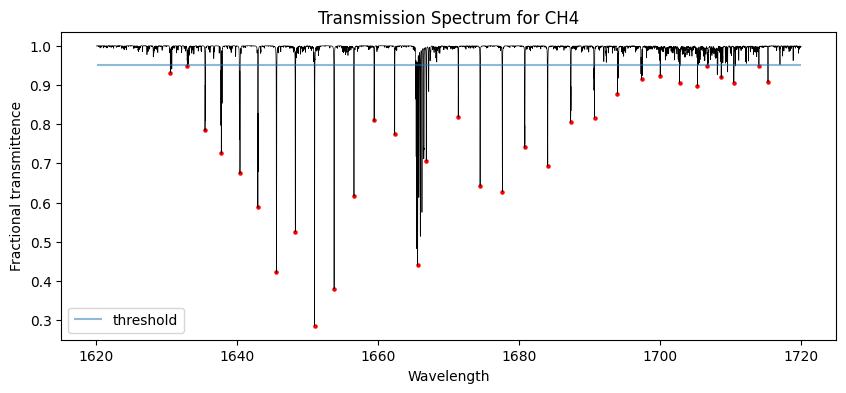

In [37]:
subset = data[index,:]

# convert wavelength into nm
subset[:,0] = subset[:,0] * 1e3

threshold_value = 0.95
peaks, properties = find_peaks(-subset[:, 1], height=-threshold_value, distance=100) # distance=100 correspond to 1nm

plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5)
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.hlines(threshold_value, subset[:, 0].min(), subset[:, 0].max(), alpha=0.5, label='threshold')
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()

# plt.xlim((1638,1642))

plt.show()


In [38]:
print(subset[peaks, 0]) 
print(subset[peaks, 1]) 

# build AFBG based on these peaks

[1630.49 1632.9  1635.41 1637.72 1640.37 1642.91 1645.54 1648.22 1650.96
 1653.73 1656.55 1659.41 1662.33 1665.59 1666.81 1671.35 1674.45 1677.61
 1680.8  1684.05 1687.3  1690.69 1693.95 1697.37 1700.01 1702.76 1705.3
 1706.71 1708.67 1710.46 1714.02 1715.31]
[0.931134 0.947978 0.78413  0.726038 0.675243 0.588176 0.422012 0.525801
 0.286138 0.379714 0.61635  0.809436 0.773745 0.440714 0.707227 0.818353
 0.642692 0.627913 0.74092  0.693845 0.805606 0.816823 0.877475 0.914384
 0.922894 0.905333 0.897958 0.949018 0.919123 0.906107 0.948625 0.908228]


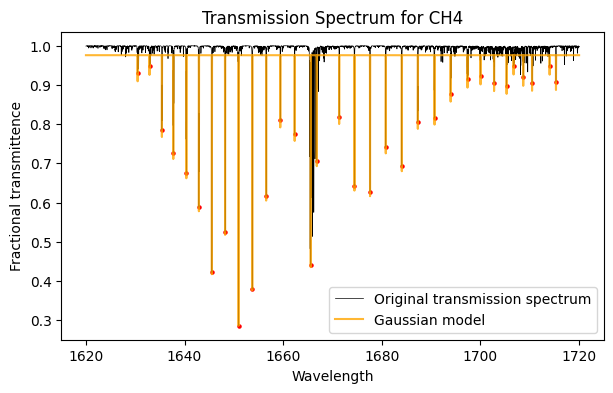

In [39]:
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, n=10000, sigma=1e-2, type='Gaussian')
plt.figure(figsize=(7,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()

# plt.xlim((1645.4,1645.6))

plt.show()

Re-define function generate_spectrum_strain to include tension tuning.

In [40]:
def generate_spectrum_strain(data, peaks, strain, n=None, sigma=1e-5, type='Gaussian'):
    locs = data[peaks, 0] * (1+7e-7 * strain)
    heights = 1 - data[peaks, 1]

    if n is None:
        n = len(data)

    wavelengths = np.linspace(data[:, 0].min(), data[:, 0].max(), n)
    transmittence = np.ones(n)

    if type == 'Gaussian':
        for i in range(len(peaks)):
            transmittence += gaussian(wavelengths, sigma=sigma, mu=locs[i], amp=heights[i])
    elif type == 'Lorentzian':
        for i in range(len(peaks)):
            transmittence += gaussian(wavelengths, sigma=sigma, mu=locs[i], amp=heights[i])
    else:
        print('Error: you need to specify a type of function to model the peak')

    transmittence *= heights.max()/transmittence.max()
    transmittence = 1 - transmittence

    return wavelengths, transmittence

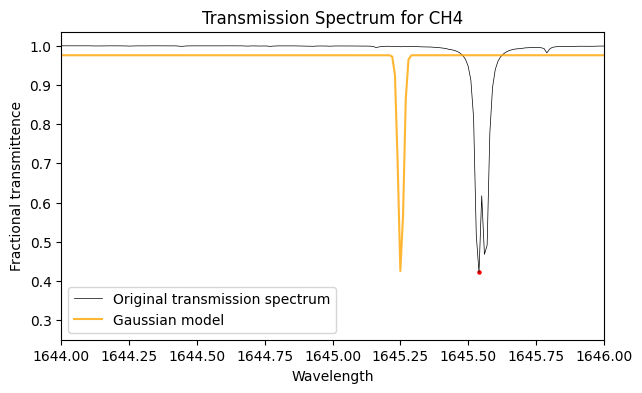

In [64]:
strain = -250

wavelength_gauss, trans_gauss = generate_spectrum_strain(subset, peaks, strain, n=10000, sigma=1e-2, type='Gaussian')
plt.figure(figsize=(7,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()

plt.xlim((1644.0,1646.0))

plt.show()

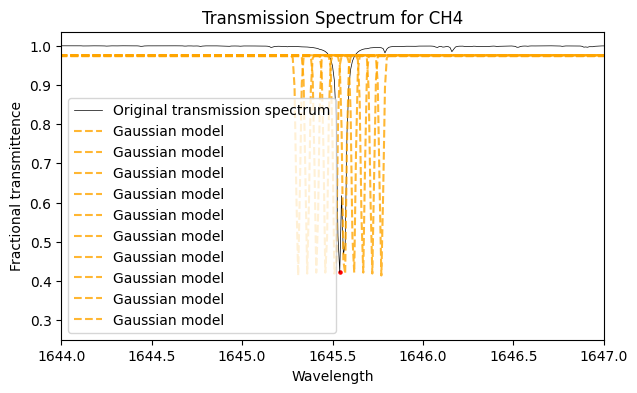

In [77]:
step = 10
strain = np.linspace(-200, 200, step)
j = 0
wavelength_gauss = np.zeros((10000,step))
trans_gauss = np.zeros((10000,step))

for i in strain: 
    wavelength_gauss[:,j], trans_gauss[:,j] = generate_spectrum_strain(subset, peaks, i, n=10000, sigma=1e-2, type='Gaussian')
    j = j + 1

plt.figure(figsize=(7,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
j=0.0
for j in range(step):
    plt.plot(wavelength_gauss[:,j], trans_gauss[:,j], color='orange', linestyle='dashed', alpha=0.8, label='Gaussian model')

plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()

plt.xlim((1644.0,1647.0))

plt.show()